# **Optimizing Partial AUC Loss on Imbalanaced Dataset (pAUC-DRO)**

**Author**: Gang Li  
**Edited by**: Zhuoning Yuan

**Introduction**

In this tutorial, we'll show how to use **pAUC_DRO** loss to train a Resnet18 model to maximize the `partial Area Under the Curve (pAUC)` on a binary image classification task with CIFAR-10 dataset. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:

<pre>
@inproceedings{zhu2022auc,
  title={When AUC meets DRO: Optimizing Partial AUC for Deep Learning with Non-Convex Convergence Guarantee},
  author={Zhu, Dixian and Li, Gang and Wang, Bokun and Wu, Xiaodong and Yang, Tianbao},
  booktitle={International Conference on Machine Learning},
  pages={27548--27573},
  year={2022},
  publisher={PMLR},
}
</pre>



## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [ ]:
!pip install libauc==1.2.0

## **Importing LibAUC**
Import required packages to use

In [ ]:
from libauc.losses.auc import pAUC_DRO_Loss
from libauc.optimizers import SOPAs
from libauc.models import resnet18
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler # data resampling (for binary class)
from libauc.metrics import pauc_roc_score

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image

## **Reproducibility**

The following function `set_all_seeds` limits the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.  The `pos_index_map` helps map global index to local index for reducing memory cost in loss function since we only need to track the indices for positive samples. Please refer to original paper [here](https://arxiv.org/pdf/2203.00176.pdf) for more details.




In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
       
       # for loss function
       self.pos_indices = np.flatnonzero(targets==1)
       self.pos_index_map = {}
       for i, idx in enumerate(self.pos_indices):
           self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, idx

## **Introduction for Loss and Optimizer**

In this section, we will introduce DRO_pAUC optimization algorithm and how to utilize KLDRO_pAUC loss function and KLDRO_pAUC optimizer. 

### **KLDRO pAUC Loss**  
Typically, AUC maximization is to optimize the following objective:  

\begin{align*}
\min_{\mathbf{w}}\frac{1}{n_+}\sum_{\mathbf{x}_i\in\mathbf{S}_+} \frac{1}{n_-}\sum_{\mathbf{x}_j\in\mathbf{S}_-} L(\mathbf{w}; \mathbf{x}_i, \mathbf{x}_j)
\end{align*}  

To pay more attention to partial difficult samples, we define a new formulation by leveraging the Distributionally Robust Optimization (DRO), which gives  
\begin{align*}
\min_{\mathbf{w}}\frac{1}{n_+}\sum_{\mathbf{x}_i\in\mathbf{S}_+} \max_{\mathbf{p}\in\Delta} \sum_j p_j L(\mathbf{w}; \mathbf{x}_i, \mathbf{x}_j) - \lambda \text{KL}(\mathbf{p}, 1/n)
\end{align*}  

It is not difficult to show that the above objective is equivalent to
\begin{align*}
\min_{\mathbf{w}}\frac{1}{n_+}\sum_{\mathbf{x}_i\in\mathbf{S}_+}\lambda \log \frac{1}{n_-}\sum_{\mathbf{x}_j\in\mathbf{S}_-}\exp(\frac{L(\mathbf{w}; \mathbf{x}_i, \mathbf{x}_j)}{\lambda})
\end{align*}

The loss is implemented in `pAUC_DRO_Loss()`.


### **KLDRO pAUC Optimizer** 

The challenge for optimizing DRO_pAUC loss is that an unbiased stochastic gradient is not readily computed since it's a two-level stochastic dependent compositional function. In order to address it, we propose an optimization algorithm called SOPA-s, whose key updates in the momentum style are as follow:

1. For each $\mathbf{x}_i\in \mathbf{B}_{+}$, update $u^{t}_i =(1-\gamma)u^{t-1}_{i} + \gamma \frac{1}{|\mathbf{B}_-|}  \sum_{\mathbf{x}_j\in \mathbf{B}_-}\exp\left(\frac{L(\mathbf{w}_t; \mathbf{x}_i, \mathbf{x}_j)}{\lambda}\right) $
2. Let $p_{ij} = \exp (L(\mathbf{w}_t; \mathbf{x}_i, \mathbf{x}_j)/\lambda)/u^{t}_{i}$, then compute a gradient estimator $\nabla_t=\frac{1}{|\mathbf{B}_{+}|}\frac{1}{|\mathbf{B}_-|}\sum_{\mathbf{x}_i\in\mathbf{B}_{+}}   \sum_{\mathbf{x}_j\in \mathbf{B}_-}p_{ij}\nabla L(\mathbf{w}_t; \mathbf{x}_i, \mathbf{x}_j)$
3. Update $\mathbf{v}_{t}=\beta\mathbf{v}_{t-1} + (1-\beta) \nabla_t$
4. Update $\mathbf{w}_{t+1}   =\mathbf{w}_t - \eta  \mathbf{v}_t$ (or Adam-style)  

$u^{t}_i$: denotes a moving average estimator for $\mathbf{E}_{\mathbf{x}_j\sim\mathbf{S}_-}\exp(\frac{L(\mathbf{w}; x_i,\mathbf{x}_j)}{\lambda})$ at $t$ iteration  
$\mathbf{w}$: denotes model's parameters  
$\nabla_t$: denotes stochastic gradient with respect to model's parameters $\mathbf{w}$ at $t$ iteration  
$\mathbf{v}$: denotes stochastic gradient momentum     
$\eta$: denotes learning rate

For more details, please refer to our [paper](https://arxiv.org/abs/2203.00176). In the implementation, we divide pAUC_DRO optimization into two parts. The first part is implemented in `pAUC_DRO_Loss` to update $u^{t}_i$. The second part is implemented in `pAUC_DRO_Optimizer`, which wraps several optimizing methods, including SGD, Momentum and ADAM to update model's parameters $\mathbf{w}$.

### **Hyper-parameters**    

**DualSampler**
- `batch_size`: how many samples per batch to load   
- `pos_num`: specify how many positive samples in each batch. It must be greater than or equal to 1


**Loss**
- `pos_len`: the size of positive sample in training dataset.
- `margin`: margin for squred hinge loss (default: 1.0)
- `gamma`: parameter for moving average, refers to $\gamma$ in step(1) (default: 0.1)
- `Lambda`: the weight for KL divergence, refers to $\lambda$ in step (1) and step (2) (default: 1.0)
    
    
**Optimizer**
- `weight_decay`: weight decay for the model parameters. Might be tuned in practice.
- `lr`: the learning rate used for SOPAs algorithm; Suggest to be tuned in practice.
- `mode`: select Adam-style or SGD-style to update model's parameters. Choose from{'sgd', 'adam'} (default: 'adam')

    
#### **Some Tips**:    
- We recommend that **pos_num** is set to **batch_size//2** based on our studies.
- In most cases, **gamma** is good when equal to 0.1, but sometimes you need to tune this parameter in the range (0, 1) to get better results.  
- **Lambda** is a sensitive parameter, tune it for better performance. Some suggested values: {0.1, 1.0, 10}  
- To further improve the model, users can also tune **margin, weight_decay** and other parameters. 


In [ ]:
# paramaters
SEED = 123
batch_size = 64
total_epochs = 60
weight_decay = 5e-4 # regularization weight decay
lr = 1e-3  # learning rate
eta = 1e1 # learning rate for control negative samples weights
decay_epochs = [20, 40]
decay_factor = 10

gamma = 0.1 
margin = 1.0
Lambda = 1.0

sampling_rate = 0.5 
num_pos = round(sampling_rate*batch_size) 
num_neg = batch_size - num_pos

## **Load Data, Preprocessing, and data loader**

In this step, we will use the [CIFAR10](http://yann.lecun.com/exdb/mnist/) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [ ]:
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

imratio = 0.2
generator = ImbalancedDataGenerator(shuffle=True, verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = generator.transform(test_data, test_targets, imratio=0.5) 

trainDataset = ImageDataset(train_images, train_labels)
testDataset = ImageDataset(test_images, test_labels, mode='test')

sampler = DualSampler(trainDataset, batch_size, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size, sampler=sampler, shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [31250], POS:NEG: [6250 : 25000], POS RATIO: 0.2000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


## **Model and Loss setup**

In [ ]:
seed = 123
set_all_seeds(seed)
model = resnet18(pretrained=False, num_classes=1, last_activation=None) 
model = model.cuda()

loss_fn = pAUC_DRO_Loss(pos_len=sampler.pos_len, margin=margin, gamma=gamma, Lambda=Lambda)
optimizer = SOPAs(model.parameters(), loss_fn=loss_fn, mode='adam', lr=lr, weight_decay=weight_decay)        

## **Training**

Now it's time for training. And we evaluate partial AUC performance with False Positive Rate(FPR) less than or equal to 0.3, i.e., FPR ≤ 0.3. Here, we use ResNet18 as an example model for demonstration.

In [ ]:
print ('Start Training')
print ('-'*30)
test_best = 0
train_list, test_list = [], []
for epoch in range(total_epochs):
    
    if epoch in decay_epochs:
         # decrease learning rate by 10x 
        optimizer.update_lr(decay_factor=10)
            
    train_pred, train_true = [], []
    model.train() 
    for idx, (data, targets, index) in enumerate(trainloader):
        data, targets  = data.cuda(), targets.cuda()
        y_pred = model(data)
        y_prob = torch.sigmoid(y_pred)
        loss = loss_fn(y_prob, targets, index_p=index) # postive index is selected inside loss function
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_pred.append(y_prob.cpu().detach().numpy())
        train_true.append(targets.cpu().detach().numpy())

    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    train_pauc = pauc_roc_score(train_true, train_pred, max_fpr=0.3)
    train_list.append(train_pauc)
    
   # evaluation
    model.eval()
    test_pred, test_true = [], [] 
    for j, data in enumerate(testloader):
        test_data, test_targets, index = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_prob = torch.sigmoid(y_pred)
        test_pred.append(y_prob.cpu().detach().numpy())
        test_true.append(test_targets.numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    val_pauc = pauc_roc_score(test_true, test_pred, max_fpr=0.3)
    test_list.append(val_pauc)
    
    if test_best < val_pauc:
       test_best = val_pauc
    
    model.train()
    print("epoch: %s, lr: %.4f, train_pauc: %.4f, test_pauc: %.4f, test_best: %.4f"%(epoch, optimizer.lr, train_pauc, val_pauc, test_best))
    

Start Training
------------------------------
epoch: 0, lr: 0.0010, train_pauc: 0.5786, test_pauc: 0.6797, test_best: 0.6797
epoch: 1, lr: 0.0010, train_pauc: 0.7022, test_pauc: 0.7290, test_best: 0.7290
epoch: 2, lr: 0.0010, train_pauc: 0.7554, test_pauc: 0.7470, test_best: 0.7470
epoch: 3, lr: 0.0010, train_pauc: 0.7884, test_pauc: 0.7697, test_best: 0.7697
epoch: 4, lr: 0.0010, train_pauc: 0.8125, test_pauc: 0.7725, test_best: 0.7725
epoch: 5, lr: 0.0010, train_pauc: 0.8281, test_pauc: 0.7553, test_best: 0.7725
epoch: 6, lr: 0.0010, train_pauc: 0.8446, test_pauc: 0.8124, test_best: 0.8124
epoch: 7, lr: 0.0010, train_pauc: 0.8538, test_pauc: 0.8089, test_best: 0.8124
epoch: 8, lr: 0.0010, train_pauc: 0.8649, test_pauc: 0.8019, test_best: 0.8124
epoch: 9, lr: 0.0010, train_pauc: 0.8773, test_pauc: 0.8040, test_best: 0.8124
epoch: 10, lr: 0.0010, train_pauc: 0.8873, test_pauc: 0.8046, test_best: 0.8124
epoch: 11, lr: 0.0010, train_pauc: 0.8918, test_pauc: 0.8392, test_best: 0.8392
epoc

## **Visualization**
Now, let's plot the curve of pAUC performance on training and test set. Furthermore, we compare our performance in terms of pAUC with the `AUCM Loss`, which can directly optimize AUROC.  For more details and tutorials about `AUCMLoss`, please refer to [AUC-M](https://github.com/Optimization-AI/LibAUC/blob/main/examples/02_Optimizing_AUROC_with_ResNet20_on_Imbalanced_CIFAR10.ipynb).

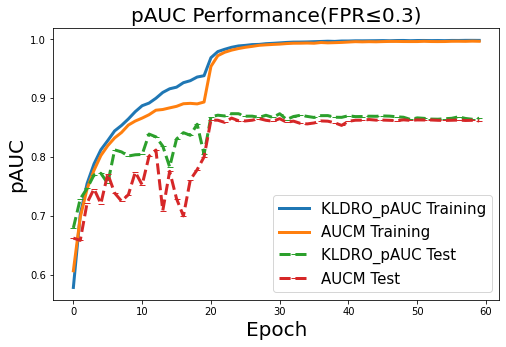

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)
###
aucm_train= [0.6069506135036445, 0.6978036932301377, 0.7463894673857081, 0.7776219948089698, 0.8027497552574762, 0.8194925184801071, 0.8326414836870717, 0.8418876286652094, 0.8545082542202714, 0.8613377917975251, 0.8663205447982314, 0.8720521974101583, 0.8797435655295311, 0.8809396206077954, 0.8836973394615497, 0.8862993963546479, 0.8907247376100926, 0.8913716767613735, 0.8904567210873551, 0.8936225492461372, 0.9540770048876036, 0.9723488133661535, 0.9781509710156533, 0.9817765145216534, 0.9844834466810455, 0.986610225327087, 0.9881808086925543, 0.9899628359094543, 0.9907810165593278, 0.9914713525781993, 0.9920222707564783, 0.9929317113720121, 0.9935210368721419, 0.993572794854696, 0.9938371343578507, 0.9935073845281966, 0.9947178127253539, 0.9941674834729468, 0.9945044055783974, 0.9948909958585506, 0.9955329256867305, 0.9961777539970935, 0.9958743720990391, 0.9961726341719099, 0.995941568038736, 0.9963039071928088, 0.9965874872432375, 0.9965767861211055, 0.9964081514670973, 0.9963576105770835, 0.9963734406282638, 0.9967885112505668, 0.9964143992297314, 0.9963215825031975, 0.9964172999093988, 0.9968314808643665, 0.9968811317731188, 0.9967179493923207, 0.9970772553897975, 0.9968263538188764]
aucm_test= [0.6624721568627451, 0.6585558039215686, 0.7224398823529412, 0.7461185882352941, 0.7209969411764705, 0.7715108235294117, 0.739145568627451, 0.7252269803921568, 0.7362687450980392, 0.7746165098039216, 0.7529456862745099, 0.8016385098039216, 0.8120752549019608, 0.7091570588235294, 0.7759422745098039, 0.7294065490196078, 0.7001150588235294, 0.761414, 0.7787230980392157, 0.8003133333333334, 0.862998980392157, 0.862715294117647, 0.8590309411764705, 0.8663745098039217, 0.8619192156862745, 0.8615073333333334, 0.8627211764705882, 0.8655584705882353, 0.8625684705882353, 0.8610763921568627, 0.8653654509803922, 0.8593325490196078, 0.8611757254901962, 0.8573677647058824, 0.8564478039215686, 0.8580612549019608, 0.8614994901960784, 0.861043725490196, 0.8583090980392156, 0.853949137254902, 0.8608719215686275, 0.862686431372549, 0.8628177254901961, 0.86389, 0.8628747058823528, 0.8629372549019607, 0.8625298431372549, 0.8619865490196079, 0.8633648235294118, 0.8624133725490196, 0.8632398823529412, 0.863091568627451, 0.8631138823529412, 0.862576, 0.8623480392156863, 0.8626336078431373, 0.8629759607843137, 0.8622864705882353, 0.8625338431372549, 0.8614151372549019]
plt.plot(train_list, label='KLDRO_pAUC Training', linewidth=3)
plt.plot(aucm_train, label='AUCM Training', linewidth=3)
plt.plot(test_list, marker='_' , linestyle='dashed', label='KLDRO_pAUC Test', linewidth=3)
plt.plot(aucm_test, marker='_' , linestyle='dashed', label='AUCM Test', linewidth=3)
plt.title('pAUC Performance(FPR≤0.3)',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('pAUC',fontsize=20)
plt.legend(fontsize=15)
plt.show()